In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import seaborn as sns

In [3]:
file_path = "cleaned_dataset.csv"  
df = pd.read_csv(file_path, na_values=[''])

In [ ]:
def cumulative_technologies(group):
    cumulative = set()  # Используем множество для хранения уникальных технологий
    result = []
    tech_years = {}  # Словарь для хранения года внедрения каждой технологии

    for year, tech in group.items():  # Используем .items() вместо .iteritems()
        if tech:  # Игнорируем пустые строки
            # Разделяем строку на отдельные технологии по запятым
            technologies = [t.strip() for t in tech.split(',')]
            for t in technologies:
                tech_years[t] = year  # Запоминаем год внедрения технологии
                cumulative.add(t)

        # Удаляем технологии, срок действия которых истек (более 3 лет назад)
        current_year = year
        cumulative = {t for t in cumulative if current_year - tech_years[t] <= 3}

        # Объединяем уникальные технологии в строку с разделителем запятая
        result.append(', '.join(sorted(cumulative)))  # Сортируем для удобства

    return result

In [ ]:
print(df.reset_index().groupby('Компания')['size_cat'].nunique().value_counts())


size_cat
1    521
2     40
Name: count, dtype: int64


In [ ]:
# Заполняем пропущенные значения в столбце 'Технология' пустой строкой
df['Технология'] = df['Технология'].fillna('')

# Сортируем данные по компании и году
df = df.sort_values(by=['Компания', 'year'])

# Применяем функцию к каждой группе
df['Кумулятивные_технологии'] = df.groupby('Компания')['Технология'].transform(cumulative_technologies)

In [ ]:
df['techdm'] = df['Кумулятивные_технологии'].apply(lambda x: 1 if x else 0)

In [ ]:
# Calculate the foundation year for each company
df['Год_основания'] = df.groupby('Компания')['year'].transform('min')

# Calculate the age of the company
df['age'] = df['year'] - df['Год_основания']

---
Строю регрессию тут

In [ ]:
# Преобразование строки технологий в список и подсчет количества
df['Количество_технологий'] = df['Кумулятивные_технологии'].apply(
    lambda x: len(set(x.split(', '))) if x else 0
)

In [ ]:
df = df.groupby(['Компания', 'year']).first()

In [ ]:
# Создаем дамми-переменные для столбца 'ind'
ind_dummies = pd.get_dummies(df['ind'], prefix='Industry', drop_first=True).set_index(df.index)
size_dummies = pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True).set_index(df.index)

# Присоединяем дамми-переменные к основному датафрейму
df = pd.concat([df, ind_dummies], axis=1)
df = pd.concat([df, size_dummies], axis=1)

In [ ]:
print("ind_dummies duplicated indices:", ind_dummies.index.duplicated().sum())
print("size_dummies duplicated indices:", size_dummies.index.duplicated().sum())


ind_dummies duplicated indices: 0
size_dummies duplicated indices: 0


In [ ]:
print("Уникальные индексы в df:", df.index.is_unique)


Уникальные индексы в df: True


In [ ]:
df.columns

Index(['Город', 'name', 'region.y', 'industry', 'claims_amount',
       'proceedings_amount', 'size_cat', 'employees', 'income', 'expenses',
       'intangibles', 'fixed_assets', 'noncurrent_assets', 'inventory',
       'net_assets', 'receivables', 'current_assets', 'assets', 'lt_debt',
       'st_debt', 'passive', 'nwc', 'equity', 'total_debt', 'sales', 'cgs',
       'commercial', 'admin_expenses', 'interest_paid', 'ebt', 'eat', 'ebit',
       'labor_costs', 'interest_payment', 'interest_coverage',
       'net_profit_margin', 'ros', 'code_okved', 'firts_number_okved', 'ind',
       'Продукт', 'Технология', 'inflation', 'Кумулятивные_технологии',
       'techdm', 'Год_основания', 'age', 'Количество_технологий',
       'Industry_elektrotehnika', 'Industry_energetika',
       'Industry_farmacevtika', 'Industry_finansovye_uslugi',
       'Industry_gazovaya_promyshlennost',
       'Industry_gosudarstvennye_struktury',
       'Industry_himicheskaya_promyshlennost',
       'Industry_industri

In [ ]:
df['log_sales'] = np.log1p(df['sales'])
df['log_cgs'] = np.log1p(df['cgs'])
df['log_eat'] = np.log1p(df['eat'])
df['log_ebit'] = np.log1p(df['ebit'])
df['log_ebt'] = np.log1p(df['ebt'])
df['log_td'] = np.log1p(df['total_debt'])
df['log_lc'] = np.log1p(df['labor_costs'])
df['log_nwc'] = np.log1p(df['nwc'])
df['log_assets'] = np.log1p(df['assets'])
df['log_inv'] = np.log1p(df['inventory'])
df['log_eq'] = np.log1p(df['equity'])
df['log_rec'] = np.log1p(df['receivables'])
df['log_na'] = np.log1p(df['net_assets'])
df['log_fa'] = np.log1p(df['fixed_assets'])
df['log_ip'] = np.log1p(df['interest_paid'])
df['log_inf'] = np.log1p(df['inflation'])

df['lag_tech'] = df.groupby(level='Компания')['Количество_технологий'].shift(1)

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufun

In [ ]:
df['employees'] = df.groupby('Компания')['employees'].fillna(method='bfill')
df['log_empl'] = np.log1p(df['employees'])


C:\Users\Home\AppData\Local\Temp\ipykernel_24364\107979903.py:1: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['employees'] = df.groupby('Компания')['employees'].fillna(method='bfill')
C:\Users\Home\AppData\Local\Temp\ipykernel_24364\107979903.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['employees'] = df.groupby('Компания')['employees'].fillna(method='bfill')


In [ ]:
list(df.columns)

['Город',
 'name',
 'region.y',
 'industry',
 'claims_amount',
 'proceedings_amount',
 'size_cat',
 'employees',
 'income',
 'expenses',
 'intangibles',
 'fixed_assets',
 'noncurrent_assets',
 'inventory',
 'net_assets',
 'receivables',
 'current_assets',
 'assets',
 'lt_debt',
 'st_debt',
 'passive',
 'nwc',
 'equity',
 'total_debt',
 'sales',
 'cgs',
 'commercial',
 'admin_expenses',
 'interest_paid',
 'ebt',
 'eat',
 'ebit',
 'labor_costs',
 'interest_payment',
 'interest_coverage',
 'net_profit_margin',
 'ros',
 'code_okved',
 'firts_number_okved',
 'ind',
 'Продукт',
 'Технология',
 'inflation',
 'Кумулятивные_технологии',
 'techdm',
 'Год_основания',
 'age',
 'Количество_технологий',
 'Industry_elektrotehnika',
 'Industry_energetika',
 'Industry_farmacevtika',
 'Industry_finansovye_uslugi',
 'Industry_gazovaya_promyshlennost',
 'Industry_gosudarstvennye_struktury',
 'Industry_himicheskaya_promyshlennost',
 'Industry_industriya_razvlecheniy',
 'Industry_informacionnaya_bezopasnost

In [ ]:
financial_columns = ['sales', 'assets', 'receivables', 'employees', 'cgs', 'inventory', 'ebt', 'labor_costs', 'equity', 'nwc', 'interest_paid', 'fixed_assets']

In [ ]:
#Определеим количество пропусков переменных
df[financial_columns].isnull().sum()

sales              1
assets             0
receivables        0
employees        101
cgs               52
inventory         66
ebt                2
labor_costs      881
equity             0
nwc                0
interest_paid    838
fixed_assets      87
dtype: int64

In [ ]:
# X — матрица предикторов без категориальных переменных
VIF_check = ['log_nwc', 'log_empl']
X_numerical = df[VIF_check]

# Добавляем константу для корректности расчетов
X_numerical = sm.add_constant(X_numerical)
X_numerical = X_numerical.dropna()

# Рассчитываем VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numerical.columns
vif_data["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]

print(vif_data)


    Feature   VIF
0     const 61.95
1   log_nwc  1.16
2  log_empl  1.16


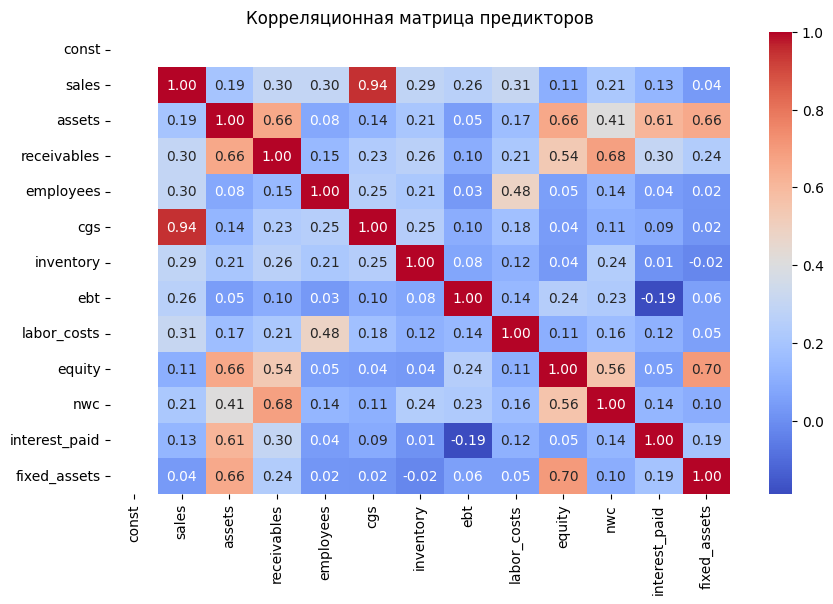

In [ ]:
corr_matrix = X_numerical.corr()

# Визуализация
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица предикторов")
plt.show()


In [ ]:
# Зависимая переменная
y = df['log_sales']
X = df[['Количество_технологий']]
X = X.join(size_dummies)
financial_controls = ['log_empl', 'log_nwc']
X = X.join(df[financial_controls])

In [ ]:
# Проверка пропущенных значений в y
print(f"Пропущенные значения в y: {y.isnull().sum()}")

# Проверка пропущенных значений в X
print(f"Пропущенные значения в X: {X.isnull().sum()}")

Пропущенные значения в y: 1
Пропущенные значения в X: Количество_технологий         0
Size_Средние предприятия      0
log_empl                    101
log_nwc                     638
dtype: int64


In [ ]:
df.columns

Index(['Город', 'name', 'region.y', 'industry', 'claims_amount',
       'proceedings_amount', 'size_cat', 'employees', 'income', 'expenses',
       ...
       'log_assets', 'log_inv', 'log_eq', 'log_rec', 'log_na', 'log_fa',
       'log_ip', 'log_inf', 'lag_tech', 'log_empl'],
      dtype='object', length=102)

# SALES / EMPLOYEES

In [ ]:
# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              log_sales   R-squared:                        0.3060
Estimator:                   PanelOLS   R-squared (Between):              0.5822
No. Observations:                3458   R-squared (Within):               0.3750
Date:                 Вс, мар 23 2025   R-squared (Overall):              0.5877
Time:                        10:35:07   Log-likelihood                   -2067.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      320.80
Entities:                         534   P-value                           0.0000
Avg Obs:                       6.4757   Distribution:                  F(4,2910)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             38.321
                            

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


# EBT / Assets

In [ ]:
y = df['log_ebt']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_assets', 'log_nwc']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                log_ebt   R-squared:                        0.1444
Estimator:                   PanelOLS   R-squared (Between):              0.9303
No. Observations:                3114   R-squared (Within):               0.2201
Date:                 Вс, мар 23 2025   R-squared (Overall):              0.9203
Time:                        10:35:07   Log-likelihood                   -4251.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      108.09
Entities:                         538   P-value                           0.0000
Avg Obs:                       5.7881   Distribution:                  F(4,2562)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             51.691
                            

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


# CGS / Inventory

In [ ]:
y = df['log_cgs']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_inv', 'log_rec']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                log_cgs   R-squared:                        0.2380
Estimator:                   PanelOLS   R-squared (Between):              0.7113
No. Observations:                4050   R-squared (Within):               0.3055
Date:                 Вс, мар 23 2025   R-squared (Overall):              0.7115
Time:                        10:35:08   Log-likelihood                   -3260.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      271.80
Entities:                         555   P-value                           0.0000
Avg Obs:                       7.2973   Distribution:                  F(4,3481)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             41.784
                            

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


# EBT / Equity

In [ ]:
y = df['log_ebt']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_eq', 'log_nwc']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:                log_ebt   R-squared:                        0.2286
Estimator:                   PanelOLS   R-squared (Between):              0.9890
No. Observations:                3053   R-squared (Within):               0.2916
Date:                 Вс, мар 23 2025   R-squared (Overall):              0.9824
Time:                        10:35:08   Log-likelihood                   -3988.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      185.92
Entities:                         529   P-value                           0.0000
Avg Obs:                       5.7713   Distribution:                  F(4,2510)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             74.025
                            

# EBT / Sales

In [ ]:
y = df['log_ebt']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_sales', 'log_nwc']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:                log_ebt   R-squared:                        0.2406
Estimator:                   PanelOLS   R-squared (Between):              0.5882
No. Observations:                3114   R-squared (Within):               0.3074
Date:                 Вс, мар 23 2025   R-squared (Overall):              0.5725
Time:                        10:35:08   Log-likelihood                   -4065.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      202.91
Entities:                         538   P-value                           0.0000
Avg Obs:                       5.7881   Distribution:                  F(4,2562)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             78.780
                            

# Sales / Assets

In [ ]:
y = df['log_sales']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_assets', 'log_nwc']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:              log_sales   R-squared:                        0.3440
Estimator:                   PanelOLS   R-squared (Between):              0.9185
No. Observations:                3526   R-squared (Within):               0.4547
Date:                 Вс, мар 23 2025   R-squared (Overall):              0.9178
Time:                        10:35:08   Log-likelihood                   -1981.3
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      389.04
Entities:                         544   P-value                           0.0000
Avg Obs:                       6.4816   Distribution:                  F(4,2968)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             63.171
                            

# Sales / Recievables

In [ ]:
y = df['log_sales']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_rec', 'log_na']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              log_sales   R-squared:                        0.3062
Estimator:                   PanelOLS   R-squared (Between):              0.7073
No. Observations:                3816   R-squared (Within):               0.4077
Date:                 Вс, мар 23 2025   R-squared (Overall):              0.7089
Time:                        10:35:08   Log-likelihood                   -2138.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      359.24
Entities:                         546   P-value                           0.0000
Avg Obs:                       6.9890   Distribution:                  F(4,3256)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             43.490
                            

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


# Total Debt / Equity

In [ ]:
y = df['log_td']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_eq', 'log_rec']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:                 log_td   R-squared:                        0.2933
Estimator:                   PanelOLS   R-squared (Between):              0.7255
No. Observations:                3816   R-squared (Within):               0.3444
Date:                 Вс, мар 23 2025   R-squared (Overall):              0.7247
Time:                        10:35:08   Log-likelihood                   -2669.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      337.90
Entities:                         546   P-value                           0.0000
Avg Obs:                       6.9890   Distribution:                  F(4,3256)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             59.345
                            

In [ ]:
from linearmodels.panel import RandomEffects
from scipy.stats import chi2

In [ ]:
fe_model = PanelOLS(y, X, entity_effects=True).fit()

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [ ]:
re_model = RandomEffects(y, X).fit()

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [ ]:
b_fe = fe_model.params
b_re = re_model.params
diff = b_fe - b_re

In [ ]:
V_fe = fe_model.cov
V_re = re_model.cov
V_diff = V_fe - V_re

In [ ]:
chi2_stat = diff.T @ np.linalg.inv(V_diff) @ diff
p_value = 1 - chi2.cdf(chi2_stat, df=len(diff))

In [ ]:
print(f'Hausman test statistic: {chi2_stat:.4f}')
print(f'P-value: {p_value:.4f}')

Hausman test statistic: 1119.8552
P-value: 0.0000
